In [1]:
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
# Rotation
from scipy.spatial.transform import Rotation as R

import rclpy
from rclpy.node import Node


# Odometry
from nav_msgs.msg import Odometry

from geometry_msgs.msg import Twist

# Tf2
from tf2_ros import TransformException
from tf2_ros.buffer import Buffer
from tf2_ros.transform_listener import TransformListener

import pickle
import glob
import os
from PyQt5.QtWidgets import QFileDialog, QWidget, QApplication
from scipy.interpolate import CubicSpline, Rbf


# Load pickle file
QApp = QApplication([])
QWidget = QWidget()
# open dialog to select file



In [2]:

def get_odom_data(dict, dict_key):
	orientations = []
	positions = []
	velocities = []
	ang_velocities = []
	timesteps = []
	for msg in dict[dict_key]:
		orientations.append(R.from_quat([msg.pose.pose.orientation.x, msg.pose.pose.orientation.y, msg.pose.pose.orientation.z, msg.pose.pose.orientation.w]))
		positions.append(np.array([msg.pose.pose.position.x, msg.pose.pose.position.y, msg.pose.pose.position.z]))
		velocities.append(np.array([msg.twist.twist.linear.x, msg.twist.twist.linear.y, msg.twist.twist.linear.z]))
		ang_velocities.append(np.array([msg.twist.twist.angular.x, msg.twist.twist.angular.y, msg.twist.twist.angular.z]))
		timesteps.append(msg.header.stamp.sec + msg.header.stamp.nanosec * 1e-9)

	odom_dict = {"orientations" : orientations, "positions" : positions, "velocities" : velocities, "ang_velocities" : ang_velocities, "timesteps" : timesteps}
	return odom_dict

def get_twist_data(dict, dict_key):
	linear = []
	angular = []
	for msg in dict[dict_key]:
		linear.append(np.array([msg.linear.x, msg.linear.y, msg.linear.z]))
		angular.append(np.array([msg.angular.x, msg.angular.y, msg.angular.z]))
	twist_dict = {"linear" : linear, "angular" : angular}
	return twist_dict

def get_joint_states(dict, dict_key):
	names = []
	positions = []
	velocities = []
	efforts = []
	timesteps = []
	for msg in dict[dict_key]:
		names.append(msg.name)
		positions.append(np.array(msg.position))
		velocities.append(np.array(msg.velocity))
		efforts.append(np.array(msg.effort))
		timesteps.append(msg.header.stamp.sec + msg.header.stamp.nanosec * 1e-9)

	joint_states_dict = {"name" : names, "positions" : positions, "velocities" : velocities, "efforts" : efforts, "timesteps" : timesteps}
	return joint_states_dict

def get_localization_data(file_path):

	with open(file_path, "rb") as f:
		data = pickle.load(f)

	positions = data[:][0]
	orientations = data[:][1]
	timesteps = data[:][2]


	localization_dict = {"orientations" : orientations, "positions" : positions, "timesteps" : timesteps}
	return localization_dict


def get_pose_array(dict, dict_key):
	plan = np.array([[pose.position.x, pose.position.y, pose.position.z] for pose in dict[dict_key].poses])
	return plan

from rosbags.rosbag2 import Reader
from rosbags.serde import deserialize_cdr

def load_from_bag(bag_file, topic, msg_type="odometry"):

	with Reader(bag_file) as reader:
        #for connection in reader.connections:
		#print(connection.topic, connection.msgtype)
		if msg_type == "odometry":
			gt_positions = []
			gt_orientations = []
			clock = []
			for connection, timestamp, rawdata in reader.messages():
				if connection.topic == topic:
					msg = deserialize_cdr(rawdata, connection.msgtype)
					#print(msg.header.frame_id)
					#print(msg.pose.pose.position.x)
					gt_positions.append([msg.pose.pose.position.x, msg.pose.pose.position.y, msg.pose.pose.position.z])
					gt_orientations.append([msg.pose.pose.orientation.x, msg.pose.pose.orientation.y, msg.pose.pose.orientation.z, msg.pose.pose.orientation.w])
					clock.append(msg.header.stamp.sec + msg.header.stamp.nanosec * 1e-9)

			return [gt_positions, gt_orientations, clock]
		
		if msg_type == "pose_array":
			plan = []
			clock = []
			for connection, timestamp, rawdata in reader.messages():
				if connection.topic == topic:
					msg = deserialize_cdr(rawdata, connection.msgtype)
					#print(msg.header.frame_id)
					#print(msg.pose.pose.position.x)
					plan = np.array([[pose.position.x, pose.position.y, pose.position.z] for pose in msg.poses])
					return plan
		
		if msg_type == "twist":
			linear = []
			angular = []
			clock = []
			for connection, timestamp, rawdata in reader.messages():
				if connection.topic == topic:
					msg = deserialize_cdr(rawdata, connection.msgtype)
					#print(msg.header.frame_id)
					#print(msg.pose.pose.position.x)
					linear.append([msg.linear.x, msg.linear.y, msg.linear.z])
					angular.append([msg.angular.x, msg.angular.y, msg.angular.z])

			return [linear, angular]




def get_link_heading(dict,):
	directions = np.zeros((len(dict["orientations"]), 3))
	for i, o in enumerate(dict["orientations"]):
		directions[i] = o.apply([1, 0, 0])

	heading_angles = np.zeros(len(dict["orientations"]))
	for i in range(len(dict["orientations"])):
		# If velocity is less than 0.2 m/s and twist.z is less than 0.1 rad/s, set heading angle to 0 and continue
		if np.linalg.norm(dict["velocities"][i]) < 0.2 and np.linalg.norm(dict["ang_velocities"][i]) < 0.1:
			heading_angles[i] = 0
			continue
		# Get angle between rear_directions[i] and rear_link_dict["velocities"][i]
		heading_angles[i] = np.arccos(np.dot(directions[i], dict["velocities"][i]) / (np.linalg.norm(directions[i]) * np.linalg.norm(dict["velocities"][i])))

	return heading_angles


In [3]:

def interpolate_points(points, num_points):
            
    # Concatenate the points to form a 3x3 array
    # points = np.array([p1, p2, p3])

    # Calculate the distances between each pair of points
    distances = np.sqrt(np.sum(np.diff(points, axis=0)**2, axis=1))

    # Calculate the cumulative distance along the curve
    cumulative_distances = np.cumsum(distances)
    cumulative_distances = np.insert(cumulative_distances, 0, 0) # Add initial distance of 0

    # Create a cubic spline interpolation of the points
    interp = CubicSpline(cumulative_distances, points, bc_type='not-a-knot')

    # Generate points along the curve at the specified resolution
    s_vals = np.linspace(cumulative_distances[0], cumulative_distances[-1], num_points)

    # for idx, dist in enumerate(cumulative_distances[:-1], ):
    #     num_points = int(np.ceil((cumulative_distances[idx + 1] - dist)/resolution))
    #     # print(num_points)
    #     s_val = np.linspace(dist, cumulative_distances[idx + 1], num_points)
    #     s_vals = np.append(s_vals, s_val[1:])

    # Generate 10 points along the curve
    interp_points = interp(s_vals)

    return interp_points

import open3d as o3d

def create_lineset(positions, color):
    lines = []
    for i in range(len(positions)-1):
        lines.append([i, i+1])
    lineset = o3d.geometry.LineSet()
    lineset.points = o3d.utility.Vector3dVector(positions)
    lineset.lines = o3d.utility.Vector2iVector(lines)
    lineset.colors = o3d.utility.Vector3dVector([color for i in range(len(lines))])
    return lineset

def create_path_pcd(positions, color):
    path_pcd = o3d.geometry.PointCloud()
    path_pcd.points = o3d.utility.Vector3dVector(positions)
    # triple the size of the point
    path_pcd.colors = o3d.utility.Vector3dVector([color for i in range(len(positions))])
    return path_pcd



Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [4]:


world_file = QFileDialog.getOpenFileName(QWidget, 'Open map file', "/home/daniel/Documents/master/maps/island_boy2.ply")[0]
if not os.path.isfile(world_file):
    raise FileNotFoundError("World file not found.")
world = o3d.io.read_triangle_mesh(world_file)
print("World loaded from file: ", world_file)
print("World has normals: ", world.has_triangle_normals(), "\nWorld has vertex normals: ", world.has_vertex_normals())
# Check if world triangles has normals
if not world.has_triangle_normals():
    print("Computing normals")
    # Compute normals
    world.compute_triangle_normals()
else:
    print("World has normals")


World loaded from file:  /home/daniel/Documents/master/maps/island_boy2.ply
World has normals:  False 
World has vertex normals:  True
Computing normals


In [5]:
#file_path = QFileDialog.getOpenFileName(QWidget, 'Open test file', '/home/daniel/Documents/master/rosbags/controller_test')[0]

file_path = '/home/daniel/Documents/master/rosbags/controller_test/controller_2m_sep/'

# with open(file_path, "rb") as f:
#     data = pickle.load(f)

base_link_2_m = load_from_bag(file_path, "/wagon/base_link_pose_gt", msg_type="odometry")
path_2m = load_from_bag(file_path, "/wayposes", msg_type="pose_array")

print(path_2m.shape)

file_path = '/home/daniel/Documents/master/rosbags/controller_test/controller_1m_sep/'
base_link_1_m = load_from_bag(file_path, "/wagon/base_link_pose_gt", msg_type="odometry")
path_1m = load_from_bag(file_path, "/wayposes", msg_type="pose_array")

print(path_1m.shape)
file_path = '/home/daniel/Documents/master/rosbags/controller_test/controller_4m_sep/'
base_link_4_m = load_from_bag(file_path, "/wagon/base_link_pose_gt", msg_type="odometry")
path_4m = load_from_bag(file_path, "/wayposes", msg_type="pose_array")

file_path = '/home/daniel/Documents/master/rosbags/controller_test/controller_6m_sep/'
base_link_6_m = load_from_bag(file_path, "/wagon/base_link_pose_gt", msg_type="odometry")
path_6m = load_from_bag(file_path, "/wayposes", msg_type="pose_array")


(55, 3)
(111, 3)


In [6]:
import distinctipy

col = distinctipy.get_colors(4, rng=500)
print(col)
# real_path_2 = create_path_pcd(path_2m, col[0])
followed_path_2 = create_lineset(base_link_2_m[0], col[0])
real_path_1 = create_path_pcd(path_1m+[0,0,1], (1,1,1))
followed_path_1 = create_lineset(base_link_1_m[0], col[1]) 
# real_path_4 = create_path_pcd(path_4m, col[2])
followed_path_4 = create_lineset(base_link_4_m[0], col[2])
# real_path_6 = create_path_pcd(path_6m, col[3])
followed_path_6 = create_lineset(base_link_6_m[0], col[3])


o3d.visualization.draw_geometries([world, real_path_1, followed_path_1, followed_path_2, followed_path_4, followed_path_6])


[(0.0, 1.0, 0.0), (1.0, 0.0, 1.0), (0.0, 0.5, 1.0), (1.0, 0.5, 0.0)]


[[0.0008095204830169678, -0.0007626639562658966, -2.4496459961054207e-06], [0.0008092224597930908, -0.0007626559818163514, -2.39004135133003e-06], [0.000809401273727417, -0.0007627365994267166, -2.5092506408808113e-06], [0.000809401273727417, -0.0007626755977980793, -2.270832061779249e-06], [0.0008089840412139893, -0.0007626962615177035, -2.568855285656202e-06], [0.0008093416690826416, -0.000762602430768311, -2.39004135133003e-06], [0.0008090436458587646, -0.000762700627092272, -2.4496459961054207e-06], [0.0008092224597930908, -0.0007627079030498862, -2.3304367065546394e-06], [0.0008093416690826416, -0.0007626976002939045, -2.5986576080438972e-06], [0.0008091628551483154, -0.0007624258869327605, -2.1218204498407722e-06], [0.0008092224597930908, -0.0007627623272128403, -2.3304367065546394e-06], [0.0008092820644378662, -0.0007626493461430073, -2.3304367065546394e-06], [0.00080910325050354, -0.0007626832230016589, -2.5390529632685066e-06], [0.0008092224597930908, -0.0007624328136444092, -

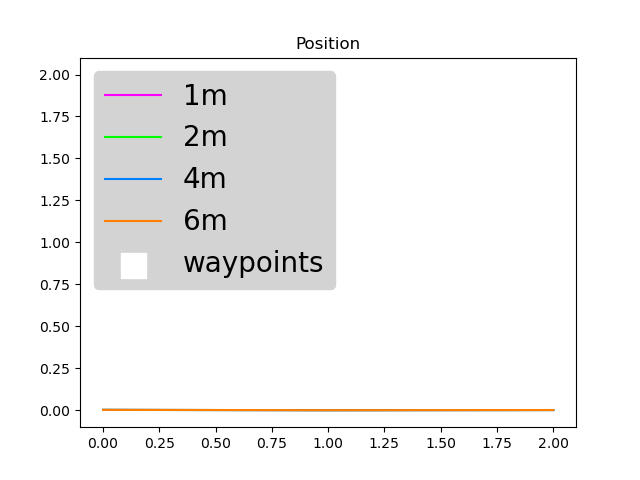

In [7]:
fig, ax = plt.subplots()
print(base_link_1_m[0])
ax.plot(np.array([base_link_1_m[0]])[0,0],  label="1m", color=col[1])
ax.plot(np.array([base_link_2_m[0]])[0,0],  label="2m", color=col[0])
ax.plot(np.array([base_link_4_m[0]])[0,0],  label="4m", color=col[2])
ax.plot(np.array([base_link_6_m[0]])[0,0],  label="6m", color=col[3])
ax.scatter(np.array([path_1m])[0,0], np.array([path_1m])[0,0], label="waypoints", marker="s",color=(1,1,1))
# set background color of legend box to blue
# leg = ax.legend()
# leg.get_frame().set_facecolor('blue')
# leg.get_frame().set_edgecolor('blue')
# leg.get_frame().set_linewidth(0.0)


leg = plt.legend(facecolor='lightgrey', edgecolor='lightgrey', framealpha=1, fontsize=20, markerscale=3)

ax.set_title("Position")
# ax[1].plot(base_link_1_m[1][:,0], label="1m", color=col[1])
# ax[1].plot(base_link_2_m[1][:,0], label="2m", color=col[0])
# ax[1].plot(base_link_4_m[1][:,0], label="4m", color=col[2])
# ax[1].plot(base_link_6_m[1][:,0], label="6m", color=col[3])
# ax[1].legend()
# ax[1].set_title("Orientation")
# ax[2].plot(base_link_1_m[2][:], label="1m", color=col[1])
# ax[2].plot(base_link_2_m[2][:], label="2m", color=col[0])
# ax[2].plot(base_link_4_m[2][:], label="4m", color=col[2])
# ax[2].plot(base_link_6_m[2][:], label="6m", color=col[3])

# ax[2].legend()
# ax[2].set_title("Time")
plt.show()




In [28]:
idx = 0
idx_last = 0
error_list_1_m = []
for i, point in enumerate(path_1m):
    idx = np.argmin(np.linalg.norm(point - base_link_1_m[0][idx_last:], axis=1))
    closests = base_link_1_m[0][idx_last+idx]
    error = np.linalg.norm(point[0:1] - closests[0:1])
    error_list_1_m.append(error)


    idx_last = idx

idx = 0
idx_last = 0
error_list_2_m = []
for i, point in enumerate(path_1m):
    idx = np.argmin(np.linalg.norm(point - base_link_2_m[0][idx_last:], axis=1))
    closests = base_link_2_m[0][idx_last+idx]
    error = np.linalg.norm(point[0:1] - closests[0:1])
    error_list_2_m.append(error)


    idx_last = idx

idx = 0
idx_last = 0
error_list_4_m = []
for i, point in enumerate(path_1m):
    idx = np.argmin(np.linalg.norm(point - base_link_4_m[0][idx_last:], axis=1))
    closests = base_link_4_m[0][idx_last+idx]
    error = np.linalg.norm(point[0:1] - closests[0:1])
    error_list_4_m.append(error)


    idx_last = idx



idx = 0
idx_last = 0
error_list_6_m = []
for i, point in enumerate(path_1m):
    idx = np.argmin(np.linalg.norm(point - base_link_6_m[0][idx_last:], axis=1))
    closests = base_link_6_m[0][idx_last+idx]
    error = np.linalg.norm(point[0:1] - closests[0:1])
    error_list_6_m.append(error)


    idx_last = idx




/tmp/ipykernel_2428/3049361253.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Dummm", "1", "2", "4", "6", "1", "2", "4", "6"])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


RMSE 1m:  9.418684228281474
RMSE 2m:  0.11120766113205918
RMSE 4m:  0.3846162787176601
RMSE 6m:  0.6735537646696653
Mean 1m:  7.344259643664352
Mean 2m:  0.07161538046010982
Mean 4m:  0.24110199854122252
Mean 6m:  0.468194885660527


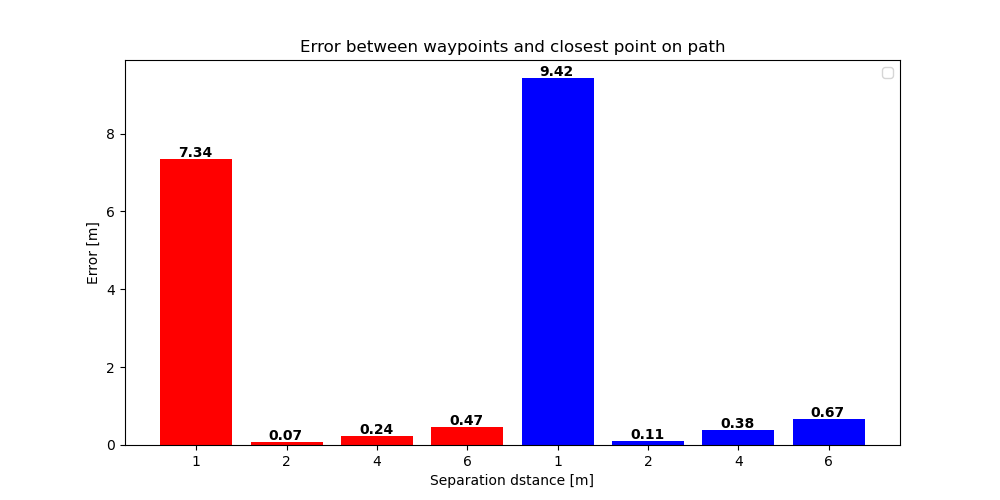

In [55]:
# Calculate the root mean squared error between full ekf and gt
rmse_1_m = np.sqrt(np.mean(np.square(error_list_1_m), axis=0))
rmse_2_m = np.sqrt(np.mean(np.square(error_list_2_m), axis=0))
rmse_4_m = np.sqrt(np.mean(np.square(error_list_4_m), axis=0))
rmse_6_m = np.sqrt(np.mean(np.square(error_list_6_m), axis=0))

print("RMSE 1m: ", rmse_1_m)
print("RMSE 2m: ", rmse_2_m)
print("RMSE 4m: ", rmse_4_m)
print("RMSE 6m: ", rmse_6_m)


# Calculate the mean error between full ekf and gt
mean_1_m = np.mean(error_list_1_m, axis=0)
mean_2_m = np.mean(error_list_2_m, axis=0)
mean_4_m = np.mean(error_list_4_m, axis=0)
mean_6_m = np.mean(error_list_6_m, axis=0)

print("Mean 1m: ", mean_1_m)
print("Mean 2m: ", mean_2_m)
print("Mean 4m: ", mean_4_m)
print("Mean 6m: ", mean_6_m)

# Create a bar plot of the error and rmse for each distance
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.bar([1,2,3,4], [mean_1_m, mean_2_m, mean_4_m, mean_6_m], color="red", label="Mean error")
ax.bar([5,6,7,8], [rmse_1_m, rmse_2_m, rmse_4_m, rmse_6_m], color="blue", label="RMSE")
# add the values to every bar in the plot
for i, v in enumerate([mean_1_m, mean_2_m, mean_4_m, mean_6_m]):
    ax.text(i+0.8, v+0.05, str(round(v, 2)), color='black', fontweight='bold')
for i, v in enumerate([rmse_1_m, rmse_2_m, rmse_4_m, rmse_6_m]):
    ax.text(i+4.8, v+0.05, str(round(v, 2)), color='black', fontweight='bold')
# ax.set_xticks([1.5, 6.5])
ax.set_xticklabels(["Dummm", "1", "2", "4", "6", "1", "2", "4", "6"])



ax.set_ylabel("Error [m]")
ax.set_xlabel("Separation dstance [m]")
ax.set_title("Error between waypoints and closest point on path")
ax.legend()


plt.savefig("/home/daniel/Documents/master/billeder/controller_path_error.png", dpi=300)


In [ ]:

fig, ax = plt.subplots()
# ax = fig.add_subplot(ax = fig)
%matplotlib widget
rear_heading_angles = get_link_heading(rear_link_dict)
base_heading_angles = get_link_heading(base_link_dict)

# Plot heading angles over time
ax.plot(rear_link_dict["timesteps"], rear_heading_angles)
ax.plot(base_link_dict["timesteps"], base_heading_angles)
ax2 = ax.twinx()
# ax2.plot(joint_states["timesteps"], np.array(joint_states["positions"])[:,3], color="red")
ax2.plot(joint_states_controller["timesteps"], np.array(joint_states_controller["positions"])[:,4]/ 4 * 0.8, color="green")
# plt.plot(cmd_timesteps, cmd_vels[:, 1])
# Add legend
ax.legend(["Rear link", "Base link"], loc="upper left")
ax2.legend(["hydraulic joint position", "Angular kink command"], loc="lower right")

ax.set_ylim([-3.15, 3.15])
ax2.set_ylim([-0.9, 0.9])

# Add labels
ax.set_title("Heading angle and joint position over time")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Heading angle (rad)")
ax2.set_ylabel("Joint position (rad)")
plt.show()


In [ ]:
file_path = QFileDialog.getOpenFileName(QWidget, 'Open file', '/home/daniel/Documents/master/rosbags/pose_data')[0]
print(file_path)

with open(file_path, "rb") as f:
    data = pickle.load(f)

base_link_dict = get_odom_data(data, "base_link_pose_gt")
joint_states = get_joint_states(data, "joint_states")
joint_states_controller = get_joint_states(data, "joint_state_controller")


file_path = QFileDialog.getOpenFileName(QWidget, 'Open file', '/home/daniel/Documents/master/rosbags/pose_data')[0]
print(file_path)

with open(file_path, "rb") as f:
    data = pickle.load(f)

base_link_dict_2 = get_odom_data(data, "base_link_pose_gt")
joint_states_2 = get_joint_states(data, "joint_states")
joint_states_controller_2 = get_joint_states(data, "joint_state_controller")

file_path = QFileDialog.getOpenFileName(QWidget, 'Open file', '/home/daniel/Documents/master/rosbags/pose_data')[0]
print(file_path)

with open(file_path, "rb") as f:
    data = pickle.load(f)

base_link_dict_3 = get_odom_data(data, "base_link_pose_gt")
joint_states_3 = get_joint_states(data, "joint_states")
joint_states_controller_3 = get_joint_states(data, "joint_state_controller")


In [ ]:
fig, ax = plt.subplots(1,1)
# create 3 subplots in 1 figure


# ax = fig.add_subplot(ax = fig)

# rear_heading_angles = get_link_heading(rear_link_dict)
base_heading_angles = get_link_heading(base_link_dict)
base_heading_angles_2 = get_link_heading(base_link_dict_2)
base_heading_angles_3 = get_link_heading(base_link_dict_3)

ax0_xlim_start = np.where(np.array(joint_states_controller["positions"])[:,4] <= -0.1)[0][0]
ax0_xlim_start = joint_states_controller["timesteps"][ax0_xlim_start] - 2
timestep_joint_controller_1 = np.array(joint_states_controller["timesteps"]) - ax0_xlim_start
timestep_base_link_1 = np.array(base_link_dict["timesteps"]) - ax0_xlim_start
timestep_joint_states_1 = np.array(joint_states["timesteps"]) - ax0_xlim_start

ax1_xlim_start = np.where(np.array(joint_states_controller_2["positions"])[:,4] <= -0.1)[0][0]
ax1_xlim_start = joint_states_controller_2["timesteps"][ax1_xlim_start] - 2
timestep_joint_controller_2 = np.array(joint_states_controller_2["timesteps"]) - ax1_xlim_start
timestep_base_link_2 = np.array(base_link_dict_2["timesteps"]) - ax1_xlim_start
timestep_joint_states_2 = np.array(joint_states_2["timesteps"]) - ax1_xlim_start




ax2_xlim_start = np.where(np.array(joint_states_controller_3["positions"])[:,4] <= -0.1)[0][0]
ax2_xlim_start = joint_states_controller_3["timesteps"][ax2_xlim_start] - 2
timestep_joint_controller_3 = np.array(joint_states_controller_3["timesteps"]) - ax2_xlim_start
timestep_base_link_3 = np.array(base_link_dict_3["timesteps"]) - ax2_xlim_start
timestep_joint_states_3 = np.array(joint_states_3["timesteps"]) - ax2_xlim_start



# Plot heading angles over time
# ax.plot(rear_link_dict["timesteps"], rear_heading_angles)
ax.plot(timestep_base_link_1, base_heading_angles, color="red", label="base link heading")
#ax[1].plot(timestep_base_link_2, base_heading_angles_2 , color="blue", label="base link heading")
#ax[2].plot(timestep_base_link_3, base_heading_angles_3 , color="green", label="base link heading")
ax2_0 = ax.twinx()
#ax2_1 = ax[1].twinx()
#ax2_2 = ax[2].twinx()

ax2_0.plot(timestep_joint_states_1, np.array(joint_states["positions"])[:,3], color="red", linestyle="dashed", label="Joint position")
#ax2_1.plot(timestep_joint_states_2, np.array(joint_states_2["positions"])[:,3], color="blue", linestyle="dashed", label="dynamic friction: 2.5")
#ax2_2.plot(timestep_joint_states_3, np.array(joint_states_3["positions"])[:,3], color="green", linestyle="dashed", label="dynamic friction: 5")

ax2_0.plot(timestep_joint_controller_1, np.array(joint_states_controller["positions"]), color="grey", linestyle="dashed", label="Angular kink command")
#ax2_1.plot(timestep_joint_controller_2, np.array(joint_states_controller_2["positions"])[:,4]/ 4 * 0.8, color="grey", linestyle="dashed", label="Angular kink command")
#ax2_2.plot(timestep_joint_controller_3, np.array(joint_states_controller_3["positions"])[:,4]/ 4 * 0.8, color="grey",linestyle="dashed",  label="Angular kink command")
# plt.plot(cmd_timesteps, cmd_vels[:, 1])
# Add legend
#ax.legend(title="base_link heading with:", loc="upper left")
#ax2.legend(title="Joint position with:", loc="lower right")

ax.set_ylim([-0.15, 0.15])
ax.legend(title="Dynamic friction: 2.5", loc="upper left")
ax2_0.set_ylim([-0.7, 0.7])
ax2_0.set_xlim([0, 17])
print(np.array(joint_states_controller["positions"])[:,4])

#ax[0].set_xlim(ax0_xlim_start - 2, ax0_xlim_start + 15)

# ax[1].set_ylim([-1.15, 1.15])
# ax[1].set_xlim([0, 17])

# #ax[1].set_xlim(ax1_xlim_start - 2, ax1_xlim_start + 15)


# ax2_1.set_ylim([-0.9, 0.9])
# ax[2].set_ylim([-1.15, 1.15])
# ax[2].set_xlim([0, 17])

# #ax[2].set_xlim(ax2_xlim_start - 2, ax2_xlim_start + 15)



# ax2_2.set_ylim([-0.9, 0.9])


# ax[1].set_ylabel("Heading angle (solid line) [rad]", fontsize=12)
# ax2_1.set_ylabel("Joint and target position (dashed line) [rad]", fontsize=12)

# add title for entire figure
fig.suptitle("Heading angle and joint position over time, 4 m/s, 0.5 rad kink")
# ax2_0.set_xlabel("Time (s)", fontsize=12)
ax.set_ylabel("Heading angle [rad]", fontsize=12)
ax2_0.set_ylabel("Joint and target position [rad]", fontsize=12)
#fig.axes.set_title("Dynamic friction: 1", loc="right", y=0.1, x=0.95)
# fig.axes[1].set_title("Dynamic friction: 2.5", loc="right", y=0.1, x=0.95)
# fig.axes[2].set_title("Dynamic friction: 5", loc="right", y=0.1, x=0.95)

# Add labels
ax.set_xlabel("Time (s)", x=0.5, y=0.1)
fig.set_figwidth(7)
fig.set_figheight(5/2)
# fig.supylabel("Heading angle (rad)")

plt.savefig("heading_angle_joint_position_4mps_0.5rad_kink.png", dpi=300, bbox_inches='tight')